Library Import

In [14]:
# pip install imblearn

In [15]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, BasicAer, IBMQ, execute, Aer, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# from ibm_quantum_widgets import *
from qiskit import Aer
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit import ParameterVector
from qiskit.visualization import circuit_drawer
from sklearn.model_selection import train_test_split

# General libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import cm
from sklearn import metrics

# QKT related
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, PauliFeatureMap
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import QuantumKernel

# Additional imports
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
# from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter


In [16]:
# Connecting with IBMQ
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options
# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

In [17]:
import sys
print(sys.getrecursionlimit())
sys.setrecursionlimit(1000)
print(sys.getrecursionlimit())

4500
1000


In [18]:
class QKTCallback:
    """Callback wrapper class."""

    def __init__(self) -> None:
        self._data = [[] for i in range(5)]

    def callback(self, x0, x1=None, x2=None, x3=None, x4=None):
        """
        Args:
            x0: number of function evaluations
            x1: the parameters
            x2: the function value
            x3: the stepsize
            x4: whether the step was accepted
        """
        self._data[0].append(x0)
        self._data[1].append(x1)
        self._data[2].append(x2)
        self._data[3].append(x3)
        self._data[4].append(x4)

    def get_callback_data(self):
        return self._data

    def clear_callback_data(self):
        self._data = [[] for i in range(5)]

Preparing the Dataset

In [19]:
# df = pd.read_csv(r'prefinaloutput.csv')
# Xtrain = df.drop('isFraud',axis=1)
# ytrain = df['isFraud']

# dft = pd.read_csv(r'testfinal.csv')
# Xtest = dft.drop(['isFraud'],axis=1)
# ytest = dft['isFraud']

# components = 17

# #To reduce training dataset size
# Xtrain, _, ytrain, _ = train_test_split(Xtrain, ytrain, stratify=ytrain, test_size=0.25)

With PCA

In [20]:
df = pd.read_csv(r'prefinaloutput.csv')
dft = pd.read_csv(r'testfinal.csv')
X = df.drop('isFraud',axis=1)
Xtest = dft.drop(['isFraud'],axis=1)
ytrain = df['isFraud']
ytest = dft['isFraud']
components = 8


pca = PCA(n_components=components)
pca.fit(X)
Xtrain = pca.transform(X)
Xtest = pca.transform(Xtest)

#To reduce training dataset size
Xtrain, _, ytrain, _ = train_test_split(Xtrain, ytrain, stratify=ytrain, test_size=0.5)

With oversampling

In [21]:
# df = pd.read_csv(r'prefinaloutput.csv')
# dft = pd.read_csv(r'testfinal.csv')
# X = df.drop('isFraud',axis=1)
# Xtest = dft.drop(['isFraud'],axis=1)
# y = df['isFraud']
# ytest = dft['isFraud']

# Xtrain, ytrain = SMOTE().fit_resample(X, y)

In [22]:
 #print(Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape)

Define the Quantum Feature Map


In [23]:
training_params = ParameterVector("θ", 1)
fm0 = QuantumCircuit(components)
for i in range(components):
    fm0.ry(training_params[0], i)

# Use ZZFeatureMap to represent input data
fm1 = ZZFeatureMap(components, entanglement='circular', reps=1)

# # Use ZFeatureMap to represent input data
# fm1 = ZFeatureMap(components, reps=2)

# # Use PauliFeatureMap to represent input data
# fm1 = PauliFeatureMap(components, reps=2)

# Create the feature map, composed of our two circuits
fm = fm0.compose(fm1)
# print(circuit_drawer(fm, output='text'))
print(fm1)
print(f"Trainable parameters: {training_params}")
print("Circuit depth: ", fm1.decompose().depth())

     ┌────────────────────────────────────────────────────────┐
q_0: ┤0                                                       ├
     │                                                        │
q_1: ┤1                                                       ├
     │                                                        │
q_2: ┤2                                                       ├
     │                                                        │
q_3: ┤3                                                       ├
     │  ZZFeatureMap(x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7]) │
q_4: ┤4                                                       ├
     │                                                        │
q_5: ┤5                                                       ├
     │                                                        │
q_6: ┤6                                                       ├
     │                                                        │
q_7: ┤7                                 

In [24]:
# fm1_transpiled = transpile(fm1, backend, optimization_level=3)
# print(fm1.decompose().depth())
# print(fm1_transpiled.depth())

In [25]:
# # Use the Aer simulator backend
# backend = Aer.get_backend("statevector_simulator")

# Use the IBM quantum backend
backend = service.backend("ibmq_kolkata")

# Instantiate quantum kernel
quant_kernel = QuantumKernel(
    fm, training_parameters=training_params, quantum_instance=backend
)

# Set up the optimizer
cb_qkt = QKTCallback()
spsa_opt = SPSA(
    maxiter=10, callback=cb_qkt.callback, learning_rate=0.1, perturbation=0.1
)

# Instantiate a quantum kernel trainer.
qkt = QuantumKernelTrainer(
    quantum_kernel=quant_kernel,
    loss="svc_loss",
    optimizer=spsa_opt,
    initial_point=[0.1] * len(training_params),
)

In [26]:
# Train the kernel using QKT directly
qka_results = qkt.fit(Xtrain, ytrain)
optimized_kernel = qka_results.quantum_kernel
print(qka_results)

Traceback (most recent call last):
  Cell In[26], line 2
    qka_results = qkt.fit(Xtrain, ytrain)
  File /opt/conda/lib/python3.10/site-packages/qiskit_machine_learning/kernels/algorithms/quantum_kernel_trainer.py:202 in fit
    output_kernel = copy.deepcopy(self._quantum_kernel)
  File /opt/conda/lib/python3.10/copy.py:172 in deepcopy
    y = _reconstruct(x, memo, *rv)
  File /opt/conda/lib/python3.10/copy.py:271 in _reconstruct
    state = deepcopy(state, memo)
  File /opt/conda/lib/python3.10/copy.py:146 in deepcopy
    y = copier(x, memo)
  File /opt/conda/lib/python3.10/copy.py:231 in _deepcopy_dict
    y[deepcopy(key, memo)] = deepcopy(value, memo)
  File /opt/conda/lib/python3.10/copy.py:172 in deepcopy
    y = _reconstruct(x, memo, *rv)
  File /opt/conda/lib/python3.10/copy.py:271 in _reconstruct
    state = deepcopy(state, memo)
  File /opt/conda/lib/python3.10/copy.py:146 in deepcopy
    y = copier(x, memo)
  File /opt/conda/lib/python3.10/copy.py:231 in _deepcopy_dict
    y

Fit and Test the Model

In [ ]:
# Instantiate the model
qsvc = QSVC(quantum_kernel=optimized_kernel)

# Fit the QSVC
qsvc.fit(Xtrain, ytrain)

# Predict the labels
labels_test = qsvc.predict(Xtest)

# Evalaute the test accuracy
accuracy_test = metrics.balanced_accuracy_score(y_true=ytest, y_pred=labels_test)
print(confusion_matrix(ytest, labels_test))
print(classification_report(ytest, labels_test))
print(f"Test Accuracy: {accuracy_test}")

## Progress so far:
Z-12-2-12:

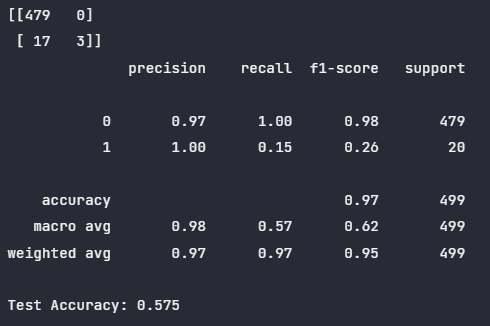

Z-17-2-1:

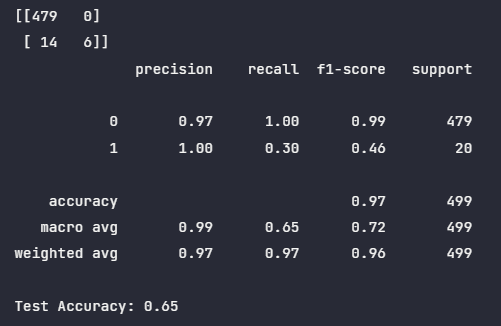

Z-6-2-1:

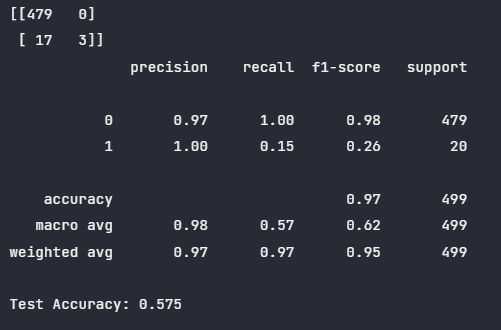

Z-6-2-6:

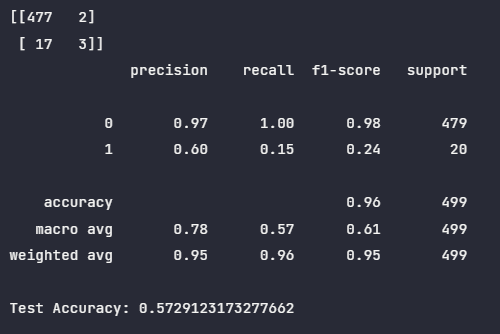

Visualize the Kernel Training Process

In [ ]:
plot_data = cb_qkt.get_callback_data()  # callback data
K = optimized_kernel.evaluate(Xtrain)  # kernel matrix evaluated on the training samples

plt.rcParams["font.size"] = 20
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot([i + 1 for i in range(len(plot_data[0]))], np.array(plot_data[2]), c="k", marker="o")
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[1].imshow(K, cmap=cm.get_cmap("bwr", 20))
fig.tight_layout()
plt.show()

In [ ]:
prep = ZZFeatureMap(17, reps=1, entanglement='circular')
# prep.decompose().draw()
prep_transpiled = transpile(prep, backend, optimization_level=3)
print(prep.decompose().depth())
print(prep_transpiled.depth())